# LAB 2.4 - Model instrumentation

In [1]:
!pip install tensorflow==2.8.0

In [2]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

In [3]:
from local.lib.rlxmoocapi import submit, session
import inspect
session.LoginSequence(endpoint=init.endpoint, course_id=init.course_id, lab_id="L02.04", varname="student");

logging in as jader.caro@udea.edu.co ... please wait

-------------
using course session 2021.deeplearning::udea.20242
success!! you are logged in
-------------


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from IPython.display import Image
import pandas as pd

%matplotlib inline

### LAB SUMMARY


In this lab you will be implementing Tensorflow Callbacks that will be invoked at different stages when a model gets trained.

Read carefully the following tutorial: [https://www.tensorflow.org/guide/keras/custom_callback](https://www.tensorflow.org/guide/keras/custom_callback)


### load sample MNIST data as customary

In [5]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print("dimension de las imagenes y las clases", X.shape, y.shape)

dimension de las imagenes y las clases (1500, 784) (1500,)


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X_train.astype(np.float32)
X_test  = X_test.astype(np.float32)
y_train_oh = np.eye(10)[y_train]
y_test_oh  = np.eye(10)[y_test]
print(X_train.shape, y_train_oh.shape)

(1200, 784) (1200, 10)


In [7]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import Callback

### A basic multi layered dense model

observe that the function allows us to parametrize the number of hidden layers and their activation function


In [8]:
def get_model(input_dim=784, output_dim=10, num_hidden_layers=6, hidden_size=10, activation="relu"):

    model = Sequential()
    model.add(Dense(hidden_size, activation=activation, input_dim=input_dim, name="Layer_%02d_Input"%(0)))

    for i in range(num_hidden_layers):
        model.add(Dense(hidden_size, activation=activation, name="Layer_%02d_Hidden"%(i+1)))

    model.add(Dense(output_dim, activation="softmax", name="Layer_%02d_Output"%(num_hidden_layers+1)))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

## TASK 1: Weights monitoring callback

Create a callback that:

- when each epoch ends, retrieves the weights of the layer with name `self.layer_name`.
- gets is kernels weights.
- computes the mean and standard deviation of those weights.
- appends them to `self.mean_per_epoch` and `self.std_per_epoch`

When used with a model, at the end of any training it will contain a list of weights means and another list of weights stds, both with one element per each epoch. With this we can monitor how the weights in a specific layer progress over the training process. Tensorboard offers a similar functionality, but the goal with this task is to get acquainted with the callback mechanism.

In [9]:
def LayerWeightsCallback(layer_name):
    class LayerWeightsCallback_class(Callback):

        def __init__(self, layer_name):
            super().__init__()
            self.mean_per_epoch = []
            self.std_per_epoch = []
            self.layer_name = layer_name

        def on_epoch_end(self, epoch, logs=None):
           w = self.model.get_layer(self.layer_name).get_weights()[0]
           mean = w.mean()
           std = w.std()
           self.mean_per_epoch.append(mean)
           self.std_per_epoch.append(std)

    return LayerWeightsCallback_class(layer_name)

manually test your code with the following cell. Your callback should report the weights mean and std doubling at every epoch, just with the same values as they are being computed within the for loop. The loop simulates training epochs.

In [10]:
model = get_model(input_dim=2, output_dim=3, num_hidden_layers=1, hidden_size=2, activation="sigmoid")
layer_names = [i.name for i in model.layers if not "Input" in i.name]
layer = model.get_layer(np.random.choice(layer_names))

cb = LayerWeightsCallback(layer.name)
cb.model = model

m, s, wh = [], [], []
for epoch in range(3):
    w = layer.get_weights()[0]
    wh.append(w)
    print ("epoch", epoch, "weights mean/std", np.mean(w),np.std(w))
    cb.on_epoch_end(epoch)
    layer.set_weights([i*2 for i in layer.get_weights()])

print ("\nweight mean at each epoch", cb.mean_per_epoch)
print ("weight std  at each epoch", cb.std_per_epoch)

epoch 0 weights mean/std 0.3392737 0.27155662
epoch 1 weights mean/std 0.6785474 0.54311323
epoch 2 weights mean/std 1.3570948 1.0862265

weight mean at each epoch [0.3392737, 0.6785474, 1.3570948]
weight std  at each epoch [0.27155662, 0.54311323, 1.0862265]


Now you can use your class to keep track of weights while training. We choose to keep track of weights with your callback for all the layers.

Observe how we plot the weights progress with the data gathered by your callback. What interpretation can you give to the plots?

In [12]:
model = get_model(num_hidden_layers=3, activation="sigmoid")
cbs = [LayerWeightsCallback(i.name) for i in model.layers]
model.fit(X_train, y_train_oh, epochs=100, batch_size=8,
          validation_data=(X_test, y_test_oh), callbacks=cbs)

Epoch 1/100
150/150 [==============================] - 3s 10ms/step - loss: 2.3579 - accuracy: 0.1242 - val_loss: 2.3156 - val_accuracy: 0.1233
Epoch 2/100
150/150 [==============================] - 1s 4ms/step - loss: 2.3037 - accuracy: 0.1242 - val_loss: 2.2924 - val_accuracy: 0.1233
Epoch 3/100
150/150 [==============================] - 1s 5ms/step - loss: 2.2872 - accuracy: 0.1242 - val_loss: 2.2760 - val_accuracy: 0.1233
Epoch 4/100
150/150 [==============================] - 1s 5ms/step - loss: 2.2664 - accuracy: 0.1242 - val_loss: 2.2487 - val_accuracy: 0.1233
Epoch 5/100
150/150 [==============================] - 1s 5ms/step - loss: 2.2241 - accuracy: 0.1258 - val_loss: 2.1949 - val_accuracy: 0.1767
Epoch 6/100
150/150 [==============================] - 1s 4ms/step - loss: 2.1497 - accuracy: 0.1817 - val_loss: 2.1083 - val_accuracy: 0.2733
Epoch 7/100
150/150 [==============================] - 1s 5ms/step - loss: 2.0465 - accuracy: 0.2283 - val_loss: 2.0164 - val_accuracy: 0.263

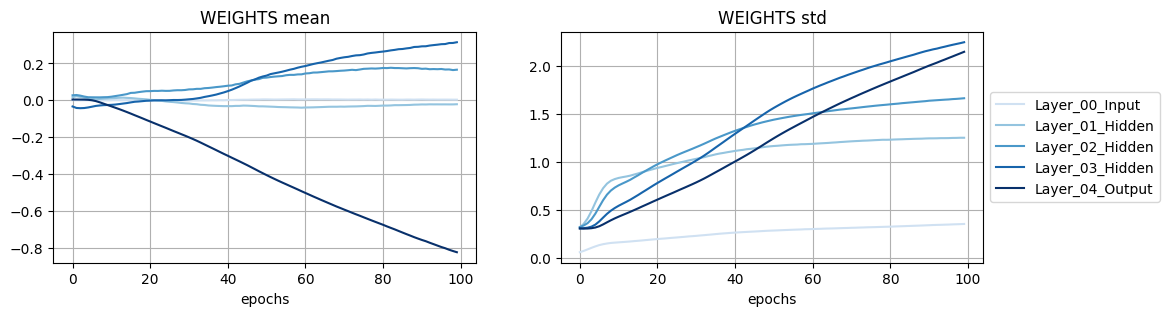

In [13]:

def plot_epochs(cbset, title=""):
    cm = plt.cm.Blues
    plt.figure(figsize=(12,3))
    plt.subplot(121)
    for i,cb in enumerate(cbset):
        plt.plot(cb.mean_per_epoch, label=cb.layer_name, color=cm(int(255*(i+1)/(len(cbset)))))
        plt.xlabel("epochs"); plt.grid(); plt.title(title+" mean")
    plt.subplot(122)
    for i,cb in enumerate(cbset):
        plt.plot(cb.std_per_epoch, label=cb.layer_name, color=cm(int(255*(i+1)/(len(cbset)))))
        plt.xlabel("epochs"); plt.grid(); plt.title(title+" std")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plot_epochs(cbs, "WEIGHTS")


**Registra tu solución en linea**

In [24]:
student.submit_task(namespace=globals(), task_id='T1');

## TASK 2: Activations monitoring callback


observe how, given a model and a certain input, we can get the activations at different layers in a very straight forward manner. If we do this before training (`.fit`) it is also ok, the model will simply use the initial random weights.

In [14]:
model = get_model(num_hidden_layers=3, activation="sigmoid")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_00_Input (Dense)      (None, 10)                7850      
                                                                 
 Layer_01_Hidden (Dense)     (None, 10)                110       
                                                                 
 Layer_02_Hidden (Dense)     (None, 10)                110       
                                                                 
 Layer_03_Hidden (Dense)     (None, 10)                110       
                                                                 
 Layer_04_Output (Dense)     (None, 10)                110       
                                                                 
Total params: 8,290
Trainable params: 8,290
Non-trainable params: 0
_________________________________________________________________


In [15]:
activations_layer_0 = model.layers[0](X_train)
activations_layer_1 = model.layers[1](activations_layer_0)
activations_layer_0.shape, activations_layer_1.shape

(TensorShape([1200, 10]), TensorShape([1200, 10]))

Create a callback that:

- when each epoch ends, feeds `self.X` into the model and retrieves the activations at the output of layer with name `self.layer_name`.
- computes the mean and standard deviation of those activations.
- appends them to `self.mean_per_epoch` and `self.std_per_epoch`

When used with a model, at the end of any training it will contain a list of activations means and another list of activation stds, both with one element per each epoch. With this we can monitor how the activation in a specific layer progress over the training process. Tensorboard offers a similar functionality, but the goal with this task is to get acquainted with the callback mechanism.

In [35]:
def TrainValActivationsCallback(layer_name, X):
    import tensorflow as tf
    class TrainValActivationsCallback_class(Callback):

        def __init__(self, layer_name, X):
            super().__init__()
            self.mean_per_epoch = []
            self.std_per_epoch = []
            self.layer_name = layer_name
            self.X = X

        def on_epoch_end(self, epoch, logs=None):
          get_layer_output = tf.keras.backend.function(
          inputs=[self.model.input],
          outputs=[self.model.get_layer(self.layer_name).output])
          a = get_layer_output([self.X])[0] # obtain the numerical values of the activations.
          mean = a.mean()
          std = a.std()
          self.mean_per_epoch.append(mean)
          self.std_per_epoch.append(std)

    return TrainValActivationsCallback_class(layer_name, X)

test your code with the following cell. Observe that

- we create a small input dataset and model
- invoke your callback implementation
- your callback must contain two lists: `mean_per_epoch` and `std_per_epoch` with one single value each
- you can check that single value with our computation. We do this computation in two different ways (1) by using explicitly the model layers; and (2) by using matrix multiplication with layers weights (`linear activation`== `no activation`)

In [30]:
X_in = np.random.random(size=(5,2)).astype(np.float32)
print ("input data\n", X_in)
model = get_model(input_dim=2, output_dim=3, num_hidden_layers=2, hidden_size=2, activation="linear")
layer_name = 'Layer_02_Hidden'
layer = model.get_layer(layer_name)

cb = TrainValActivationsCallback(layer.name, X_in)
cb.model = model
cb.on_epoch_end(epoch)

print ("\nactivations at", layer_name)
print ("\nactivation mean/std with your callback", cb.mean_per_epoch, cb.std_per_epoch)

l0,l1,l2,l3 = model.layers
a = l2(l1(l0(X_in))).numpy()
print ("using model layer functions            ", a.mean(), a.std())

a = X_in.dot(l0.get_weights()[0]).dot(l1.get_weights()[0]).dot(l2.get_weights()[0])
print ("manual matrix mult linear activation   ", a.mean(), a.std())

input data
 [[0.95040727 0.13689582]
 [0.22774231 0.25720546]
 [0.55593187 0.795253  ]
 [0.30785182 0.9045546 ]
 [0.8693744  0.94914985]]

activations at Layer_02_Hidden

activation mean/std with your callback [<KerasTensor: shape=() dtype=float32 (created by layer 'tf.math.reduce_mean')>] [<KerasTensor: shape=() dtype=float32 (created by layer 'tf.math.reduce_std')>]
using model layer functions             0.006070018 0.38316882
manual matrix mult linear activation    0.0060700206 0.38316882


Now you can use your class to keep track of activations while training. We choose to keep track of activations with your callback for all the layers.

Observe how we plot the activations progress with the data gathered by your callback. What interpretation can you give to the plots?

In this case, we are creating a callback for each layer for train and for test data. If activations are similar in both train and test it may mean that the train/test splits are being treated similarly by the model.

In [18]:
y_train_oh.shape[1]

10

In [36]:
model = get_model(num_hidden_layers=3, activation="sigmoid", input_dim=X_train.shape[1], output_dim=y_train_oh.shape[1])
cbs_train = [TrainValActivationsCallback(i.name, X_train) for i in model.layers]
cbs_test  = [TrainValActivationsCallback(i.name, X_test) for i in model.layers]
model.fit(X_train, y_train_oh, epochs=100, batch_size=32,
          validation_data=(X_test, y_test_oh), callbacks=cbs_train+cbs_test)

Epoch 1/100
38/38 [==============================] - 1s 15ms/step - loss: 2.3713 - accuracy: 0.1033 - val_loss: 2.3104 - val_accuracy: 0.1100
Epoch 2/100
38/38 [==============================] - 0s 12ms/step - loss: 2.3234 - accuracy: 0.1033 - val_loss: 2.2904 - val_accuracy: 0.1100
Epoch 3/100
38/38 [==============================] - 0s 13ms/step - loss: 2.3044 - accuracy: 0.1033 - val_loss: 2.2819 - val_accuracy: 0.1233
Epoch 4/100
38/38 [==============================] - 0s 10ms/step - loss: 2.2923 - accuracy: 0.1908 - val_loss: 2.2767 - val_accuracy: 0.2033
Epoch 5/100
38/38 [==============================] - 0s 12ms/step - loss: 2.2833 - accuracy: 0.2033 - val_loss: 2.2720 - val_accuracy: 0.2033
Epoch 6/100
38/38 [==============================] - 0s 11ms/step - loss: 2.2746 - accuracy: 0.1933 - val_loss: 2.2647 - val_accuracy: 0.2000
Epoch 7/100
38/38 [==============================] - 0s 11ms/step - loss: 2.2635 - accuracy: 0.2067 - val_loss: 2.2546 - val_accuracy: 0.2067
Epoch 

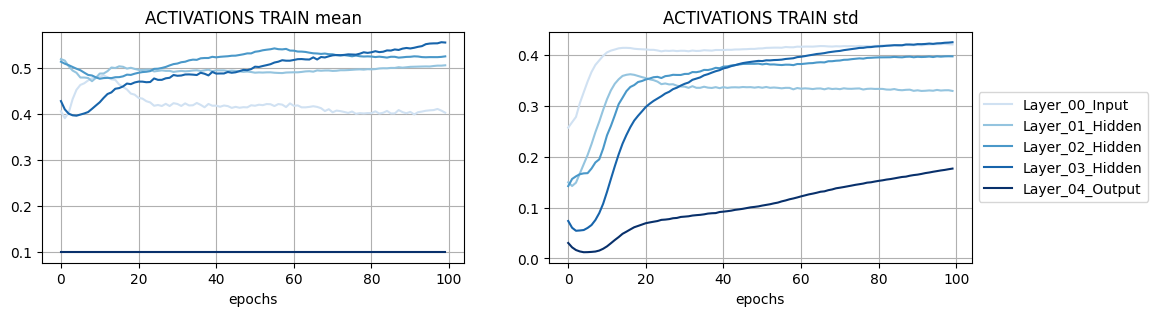

In [37]:

plot_epochs(cbs_train, "ACTIVATIONS TRAIN")


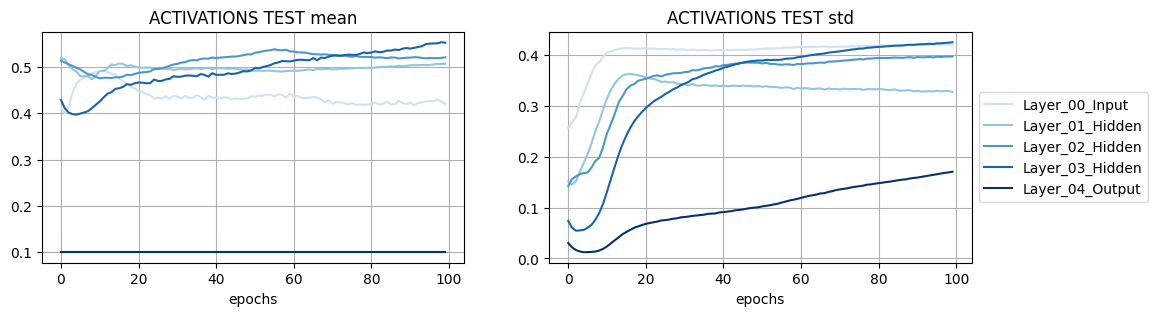

In [38]:

plot_epochs(cbs_test, "ACTIVATIONS TEST")


**Registra tu solución en linea**

In [39]:
student.submit_task(namespace=globals(), task_id='T2');